In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle

In [2]:
data = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/data.csv', index_col = 0)
labels = pd.read_csv('TCGA-PANCAN-HiSeq-801x20531/labels.csv')

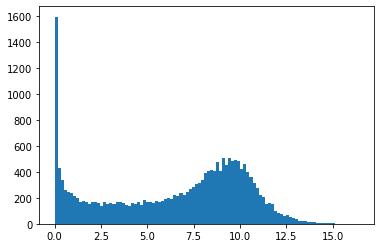

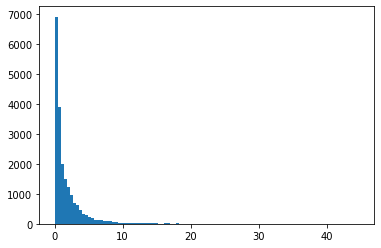

In [3]:
mean_arr = np.mean(data, 0)
var_arr = np.var(data, 0)
plt.hist(mean_arr, 100)
plt.show()
plt.hist(var_arr, 100)
plt.show()

In [4]:
print('There are %s constant features.' % len(np.argwhere(np.array(var_arr == 0))))

There are 267 constant features.


In [5]:
data_new = data.drop(data.columns[np.argwhere(np.array(var_arr == 0)).flatten()], axis = 1)
mean_arr = np.mean(data_new, 0)
var_arr = np.var(data_new, 0)
min_var = 2
data_new.drop(data_new.columns[np.argwhere(np.array(var_arr < min_var)).flatten()], axis = 1, inplace = True)
mean_arr = np.mean(data_new, 0)
var_arr = np.var(data_new, 0)
print(data_new.shape)

(801, 5579)


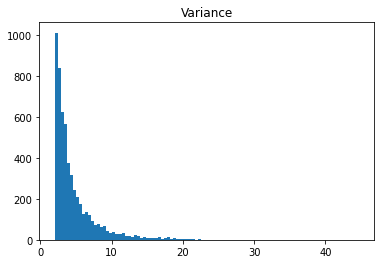

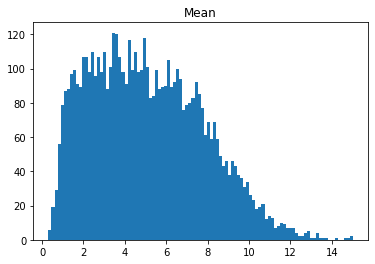

In [6]:
plt.hist(var_arr, 100)
plt.title('Variance')
plt.show()
plt.hist(mean_arr, 100)
plt.title('Mean')
plt.show()

In [7]:
data_new_standardized = (data_new - mean_arr)/(var_arr ** (1/2))

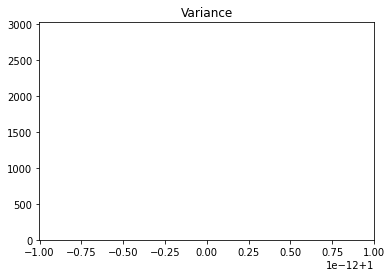

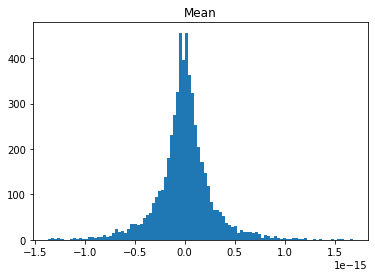

In [8]:
mean_arr = np.mean(data_new_standardized, 0)
var_arr = np.var(data_new_standardized, 0)
plt.hist(var_arr)
plt.title('Variance')
plt.show()
plt.hist(mean_arr, 100)
plt.title('Mean')
plt.show()

In [9]:
cov = data_new_standardized.cov()

In [10]:
eigenvalues = pickle.load( open( "eigenvalues_first_800.pkl", "rb" ) )
eigenvectors = pickle.load( open( "eigenvectors_first_800.pkl", "rb" ) )

In [11]:
data_pc = np.real(np.array(data_new_standardized@eigenvectors))

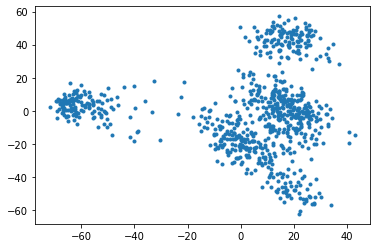

In [12]:
plt.plot(data_pc[:,0], data_pc[:,1], '.')

In [13]:
def calculate_S(data, labels, dist):
    n_data = data.shape[0]
    a = np.zeros(n_data)
    b = np.zeros(n_data)
    for l in range(n_data):
        curr_cluster = labels[l]
        curr_indices = np.argwhere(labels == curr_cluster).flatten()
        a[l] = 1/len(curr_indices)*np.sum(dist[l, curr_indices])
        cluster_dists = np.zeros(K)
        for k in range(K):
            if k == curr_cluster:
                continue
            curr_indices_k = np.argwhere(labels == k).flatten() 
            cluster_dists[k] = 1/len(curr_indices_k)*np.sum(dist[l, curr_indices_k])
        cluster_dists = np.delete(cluster_dists, curr_cluster)
        b[l] = np.min(cluster_dists)
    s = (b-a)/np.maximum(a,b)
    S = np.mean(s)
    return S
    
def plot_PC(data, labels, K, pc1 = 0, pc2 = 1):
    for k in range(K):
        curr_indices = np.argwhere(labels == k).flatten()
        plt.plot(data[curr_indices, 0], data[curr_indices, 1], '.')
    plt.show()


K = 2


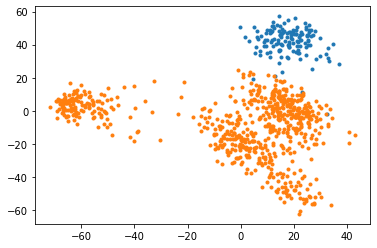

K = 3


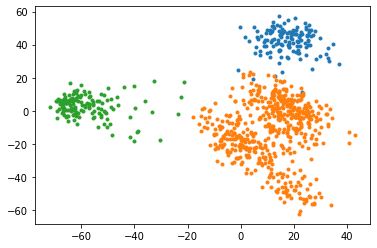

K = 4


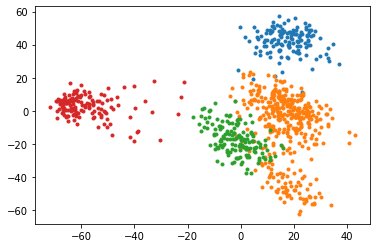

K = 5


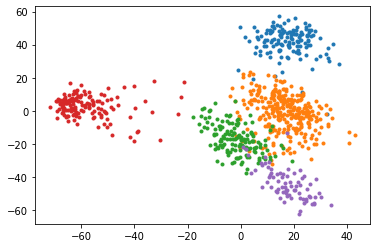

K = 6


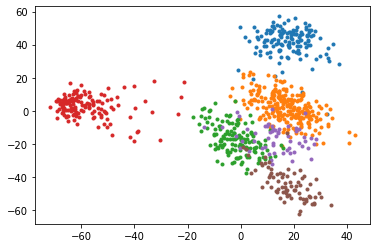

K = 7


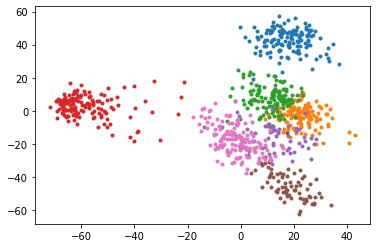

K = 8


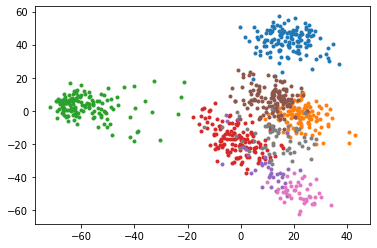

K = 9


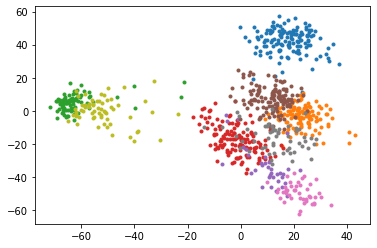

In [14]:
from sklearn.mixture import GaussianMixture
from scipy.spatial.distance import cdist
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

K_max = 10
n_tries = 10
K_array = list(range(2, K_max))
S_arr = np.zeros(len(K_array))
S_new_arr = np.zeros(len(K_array))
calinski_arr = np.zeros(len(K_array))
davies_arr = np.zeros(len(K_array))
dist = cdist(data_pc, data_pc)

for i,K in enumerate(K_array):
    S_try = []
    S_new_try = []
    calinski_try = []
    davies_try = []
    for j in range(n_tries):
        gm = GaussianMixture(n_components=K, random_state=0, n_init = 1).fit(data_pc)
        labels = gm.predict(data_pc)
        S_try.append(calculate_S(data_pc, labels, dist))
        calinski_try.append(calinski_harabasz_score(data_pc, labels))
        davies_try.append(davies_bouldin_score(data_pc, labels))
        S_new_try.append(silhouette_score(data_pc, labels))
        
    S_arr[i] = np.mean(S_try)
    calinski_arr[i] = np.mean(calinski_try)
    davies_arr[i] = np.mean(davies_try)
    S_new_arr[i] = np.mean(S_new_try)
    print("K = %s" % K)
    plot_PC(data_pc, labels, K)

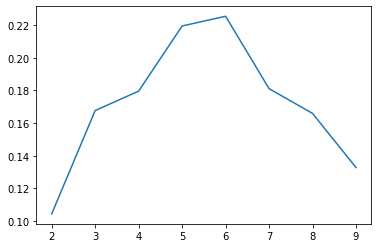

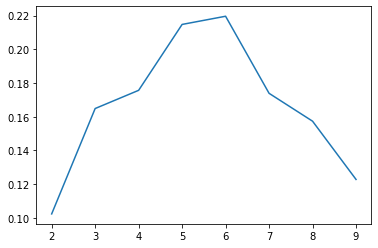

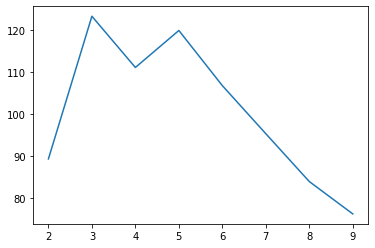

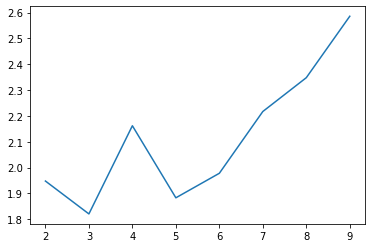

In [15]:
plt.plot(K_array, S_arr)
plt.show()

plt.plot(K_array, S_new_arr)
plt.show()

plt.plot(K_array, calinski_arr)
plt.show()

plt.plot(K_array, davies_arr)
plt.show()